In [3]:
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import numpy as np

%run ../JM_custom_figs.py
%run ../fx4roc.py
%run ../figs4roc.py

In [4]:
datafolder = "C:\\Github\\Distraction-Paper\\data\\"
figfolder = "C:\\Github\\Distraction-Paper\\figs\\"
outputfolder = "C:\\Github\\Distraction-Paper\\output\\"

try:
    pickle_in = open(datafolder + "distraction_data_only_snips.pickle", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[modDict, disDict, habDict] = dill.load(pickle_in)

In [6]:
# Makes lick snips for all distractors and then flattens (e.g. pools snips from all rats)

def make_lick_snips(d, pre=5, post=15):
    snips = []
    for dis in d['distractors']:
        snips.append([lick-dis for lick in d['licks'] if (lick-dis>-pre) and (lick-dis<post) ])
        
    return snips

rats = disDict.keys()

mod_lick_snips, dis_lick_snips = [], []
for rat in rats:
    d = modDict[rat]
    mod_lick_snips.append(make_lick_snips(d))
    
    d = disDict[rat]
    dis_lick_snips.append(make_lick_snips(d))

mod_lick_snips_flat = flatten_list(mod_lick_snips)
dis_lick_snips_flat = flatten_list(dis_lick_snips)

In [19]:
# This cell uses a simple function to check whether any licks occur between 0 and 1 seconds (i.e. is it a distracted snip or not)

def check_val_between(data, x1=0.001, x2=1.000):
    """ Checks if there is a value in a list between two numbers"""
    
    vals = [1 for d in data if d>x1 and d<x2]
    
    if sum(vals) > 0:
        return True
    else:
        return False
    
mod_dis_snips = [snip for snip in mod_lick_snips_flat if not check_val_between(snip)]
mod_notdis_snips = [snip for snip in mod_lick_snips_flat if check_val_between(snip)]

dis_dis_snips = [snip for snip in dis_lick_snips_flat if not check_val_between(snip)]
dis_notdis_snips = [snip for snip in dis_lick_snips_flat if check_val_between(snip)]

print(f"Number of DISTRACTED trials on MODELLED day is {len(mod_dis_snips)}")
print(f"Number of NOT DISTRACTED trials on MODELLED day is {len(mod_notdis_snips)}")
print(f"Number of DISTRACTED trials on DISTRACTION day is {len(dis_dis_snips)}")
print(f"Number of NOT DISTRACTED trials on DISTRACTION day is {len(dis_notdis_snips)}")

Number of DISTRACTED trials on MODELLED day is 30
Number of NOT DISTRACTED trials on MODELLED day is 741
Number of DISTRACTED trials on DISTRACTION day is 344
Number of NOT DISTRACTED trials on DISTRACTION day is 397


In [18]:
# Cell to test that code using check_val_between is selecting correct number of distracted and non-distracted snips
snips=[]

for rat in rats:
    d = modDict[rat]
    snips.append(len(d['snips_not-distracted']['filt_z']))
sum(snips)

741

In [20]:
# turns snips into binned data

# bins = np.arange(-10, 20, 1)
bins = np.arange(-5, 15, 1)
mod_dis_hist = [np.histogram(snip, bins=bins)[0] for snip in mod_dis_snips]
mod_notdis_hist = [np.histogram(snip, bins=bins)[0] for snip in mod_notdis_snips]

dis_dis_hist = [np.histogram(snip, bins=bins)[0] for snip in dis_dis_snips]
dis_notdis_hist = [np.histogram(snip, bins=bins)[0] for snip in dis_notdis_snips]

In [21]:
# Cell to run ROC analysis - takes a while so commented out unless needed
import time
start_time = time.time()

a, p = nanroc(mod_dis_hist, dis_dis_hist, n4shuf=2000)

print(f"--- Total ROC analysis took {(time.time() - start_time)} seconds ---")

Analysing column 0
Analysing column 1
Analysing column 2
Analysing column 3
Analysing column 4
Analysing column 5
Analysing column 6
Analysing column 7
Analysing column 8
Analysing column 9
Analysing column 10
Analysing column 11
Analysing column 12
Analysing column 13
Analysing column 14
Analysing column 15
Analysing column 16
Analysing column 17
Analysing column 18
--- Total ROC analysis took 119.07851552963257 seconds ---


Text(0.5, 0, 'Time from distractor (s)')

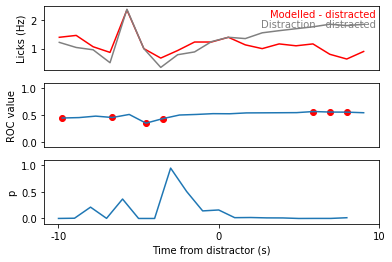

In [34]:
f, ax = plt.subplots(nrows=3)

ax[0].plot(np.mean(mod_dis_hist, axis=0), color='red')
ax[0].plot(np.mean(dis_dis_hist, axis=0), color='grey')

ax[0].set_ylabel('Licks (Hz)')
ax[0].set_xticks([])

ax[0].text(0.99, 0.95, 'Modelled - distracted', color='red', ha='right', va='top', transform=ax[0].transAxes)
ax[0].text(0.99, 0.80, 'Distraction - distracted', color='grey', ha='right', va='top', transform=ax[0].transAxes)

ax[1].plot(a)
ax[1].set_ylabel('ROC value')
ax[1].set_xticks([])

threshold = 0.05/len(p)
sigpoints = np.array([pval < threshold for pval in p], dtype=bool)

xdata = [x for x, L in zip(range(len(sigpoints)), sigpoints) if L]
ydata = logical_subset(a, sigpoints)
ax[1].scatter(xdata, ydata, color='red')

ax[1]. set_ylim([-0.1, 1.1])

ax[2].plot(p)
ax[2].set_ylim([-0.1, 1.1])
ax[2].set_ylabel('p')

ax[2].set_xticks([0, 10, 20])
ax[2].set_xticklabels(['-10', '0', '10'])
ax[2].set_xlabel('Time from distractor (s)')

In [27]:
savefile=True
if savefile:
    pickle_out = open(outputfolder+"roc_results_licks_mod-disVdis-dis", 'wb')
    dill.dump([a, p], pickle_out)
    pickle_out.close()

In [28]:
# Cell to run ROC analysis - takes a while so commented out unless needed
import time
start_time = time.time()

a, p = nanroc(mod_notdis_hist, dis_notdis_hist, n4shuf=2000)

print(f"--- Total ROC analysis took {(time.time() - start_time)} seconds ---")

Analysing column 0
Analysing column 1
Analysing column 2
Analysing column 3
Analysing column 4
Analysing column 5
Analysing column 6
Analysing column 7
Analysing column 8
Analysing column 9
Analysing column 10
Analysing column 11
Analysing column 12
Analysing column 13
Analysing column 14
Analysing column 15
Analysing column 16
Analysing column 17
Analysing column 18
--- Total ROC analysis took 301.8006203174591 seconds ---


In [29]:
savefile=True
if savefile:
    pickle_out = open(outputfolder+"roc_results_licks_mod-notdisVdis-notdis", 'wb')
    dill.dump([a, p], pickle_out)
    pickle_out.close()

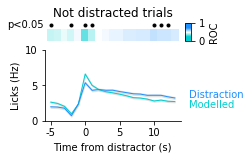

In [90]:
%run ../figs4roc.py

try:
    pickle_in = open(outputfolder+"roc_results_licks_mod-notdisVdis-notdis", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[a, p] = dill.load(pickle_in)

f = plt.figure(figsize=(3.4,2))
f, ax = plot_ROC_and_line(f, a, p, mod_notdis_hist, dis_notdis_hist,
                 cdict = [(0, 'darkturquoise'), (0.25, 'darkturquoise'), (0.5, 'white'), (0.75, 'dodgerblue'), (1, 'dodgerblue')],
                 colors = ['darkturquoise', 'dodgerblue'],
                 labels=['Modelled', 'Distraction'],
                 labeloffset=0.5,
                 ylabel='Licks (Hz)')

ax[1].set_yticks([0, 5, 10])
ax[0].set_title('Not distracted trials')

f.savefig(figfolder+"fig4_mod-v-dis_notdistracted trials.pdf")

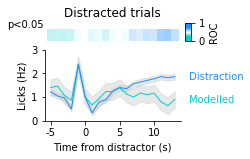

In [86]:
try:
    pickle_in = open(outputfolder+"roc_results_licks_mod-disVdis-dis", 'rb')
except FileNotFoundError:
        print('Cannot access pickled file')

[a, p] = dill.load(pickle_in)


f = plt.figure(figsize=(3.4,2))
f, ax = plot_ROC_and_line(f, a, p, mod_dis_hist, dis_dis_hist,
                 cdict = [(0, 'darkturquoise'), (0.25, 'darkturquoise'), (0.5, 'white'), (0.75, 'dodgerblue'), (1, 'dodgerblue')],
                 colors = ['darkturquoise', 'dodgerblue'],
                 labels=['Modelled', 'Distraction'],
                 labeloffset=0,
                 ylabel='Licks (Hz)')

ax[1].set_yticks([0, 1, 2, 3])
ax[0].set_title('Distracted trials')

f.savefig(figfolder+"fig4_mod-v-dis_distracted trials.pdf")


In [88]:
len(mod_dis_hist[0])

19